In [6]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import datetime
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

In [23]:
questions = []
paras = []
para_match_precisions = []
para_match_recalls = []
para_match_f1s = []
with open('../input/cleaned/train_round_0.json') as f:
    for line in f:
        sample =json.loads(line.strip())
        for doc in sample['documents']:
            para_match_precisions.extend(doc['para_match_precisions'])
            para_match_recalls.extend(doc['para_match_recalls'])
            para_match_f1s.extend(doc['para_match_f1s'])
            
            questions.extend([sample['question']] * len(doc['paragraphs']))
            paras.extend(doc['paragraphs'])

In [24]:
para_match_score_df = pd.DataFrame()
para_match_score_df['question'] = questions
para_match_score_df['para'] = paras
para_match_score_df['para_match_precision'] = para_match_precisions
para_match_score_df['para_match_recall'] = para_match_recalls
para_match_score_df['para_match_f1'] = para_match_f1s

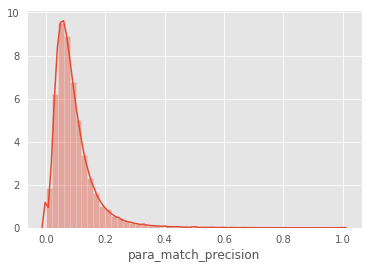

In [25]:
sns.distplot(para_match_score_df['para_match_precision'])
plt.show()

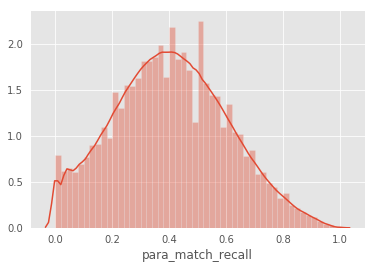

In [10]:
sns.distplot(para_match_score_df['para_match_recall'])
plt.show()

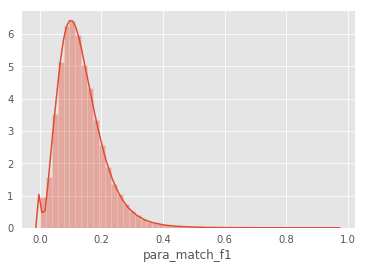

In [11]:
sns.distplot(para_match_score_df['para_match_f1'])
plt.show()

In [28]:
print('f1=0, ', para_match_score_df[para_match_score_df['para_match_f1'] < 0.1].shape[0])

f1=0,  542688


In [13]:
para_match_score_df.head()

,question,para,para_match_precision,para_match_recall,para_match_f1
0,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,据美国媒体9月10日报道称，近日部署在美国东海岸多个军事基地的3艘核动力航母出现了罕见的一幕...,0.089820,0.428571,0.148515
1,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,美媒表示，由于担忧飓风和可能出现的海啸对美国海军的宝贵资产造成影响，美国舰队司令部司令克里斯...,0.050847,0.685714,0.094675
2,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,美媒表示，美国军舰紧急出港躲避恶劣天气的情况并不罕见，在过去几年中美国海军曾多次因为飓风和海...,0.047809,0.685714,0.089385
3,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,艾森豪威尔号航空母舰。它是美国尼米兹级核动力航空母舰的二号舰，舰名承袭自参加过第二次世界大战...,0.230769,0.600000,0.333333
4,参与美韩举行的“鹞鹰”联合军演的是哪艘航母？,1970年6月29日，位于维吉尼亚州纽波特纽斯的纽波特纽斯造船厂正式开始艾森豪威尔号的建造工...,0.105769,0.628571,0.181070


## 验证 f1最低的 para，是否为supporting paragraph 的情况

In [29]:
match_score_pattern = 'f1'
low_match_score_threshold = 0.03

In [30]:
supported_para_ids = []
low_match_score_para_ids = []
with open('../input/cleaned/train_round_0.json') as f:
    for line in f:
        sample =json.loads(line.strip())
        for doc in sample['documents']:
            if doc['is_selected']:
                supported_para_ids.append(doc['supported_para_ids'])
                match_score = 'para_match_{}s'.format(match_score_pattern)
                scores = np.array(doc[match_score])
                low_match_score_para_ids.append(np.where(scores <= low_match_score_threshold)[0].tolist())


In [31]:
df = pd.DataFrame({
    'supported_para_ids': supported_para_ids,
    'low_match_score_para_ids': low_match_score_para_ids
})

In [32]:
df.sample(5)

,supported_para_ids,low_match_score_para_ids
18048,[5],[]
17172,[1],[]
8997,[2],[]
13731,[0],[]
11412,[0],[]


In [33]:
def check_lowf1_para_is_supported(row):
    for pid in row['low_match_score_para_ids']:
        if pid in row['supported_para_ids']:
            return True
    return False

In [34]:
df['low_match_score_para_is_supported'] = df.apply(lambda row: check_lowf1_para_is_supported(row), axis=1)

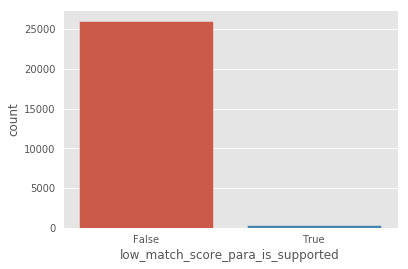

In [35]:
sns.countplot(df['low_match_score_para_is_supported'])

In [36]:
print(df['low_match_score_para_is_supported'].value_counts())

False    26047
True       324
Name: low_match_score_para_is_supported, dtype: int64


In [22]:
df.shape

(26371, 3)

## 段落筛选后的长度分布

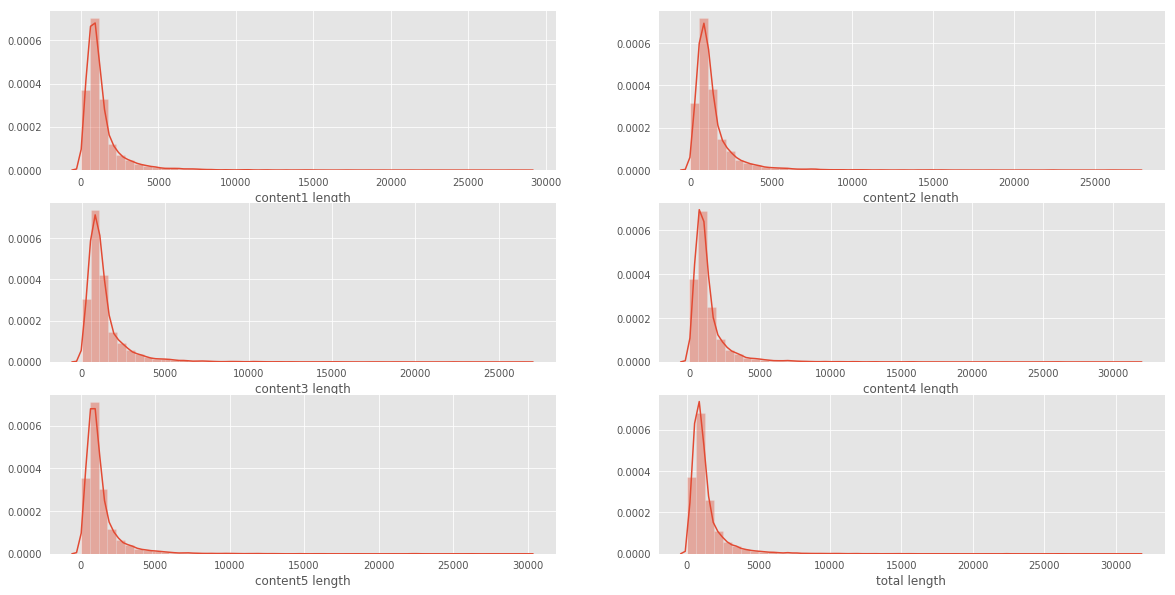

In [5]:
import json

train_content1_len = []
train_content2_len = []
train_content3_len = []
train_content4_len = []
train_content5_len = []
with open('../input/extracted/train_round_0.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        docs = sample['documents']
        train_content1_len.append(len(''.join(docs[0]['paragraphs'])))
        train_content2_len.append(len(''.join(docs[1]['paragraphs'])))
        train_content3_len.append(len(''.join(docs[2]['paragraphs'])))
        train_content4_len.append(len(''.join(docs[3]['paragraphs'])))
        train_content5_len.append(len(''.join(docs[4]['paragraphs'])))

plt.figure(figsize=(20,10))
plt.subplot(321)
sns.distplot(train_content1_len, axlabel='content1 length')
plt.subplot(322)
sns.distplot(train_content2_len, axlabel='content2 length')
plt.subplot(323)
sns.distplot(train_content3_len, axlabel='content3 length')
plt.subplot(324)
sns.distplot(train_content4_len, axlabel='content4 length')
plt.subplot(325)
sns.distplot(train_content5_len, axlabel='content5 length')
plt.subplot(326)
sns.distplot(train_content1_len + train_content2_len + train_content3_len + 
             train_content4_len + train_content5_len, axlabel='total length')
plt.show()

In [2]:
train_content1_paras = []
train_content2_paras = []
train_content3_paras = []
train_content4_paras = []
train_content5_paras = []
with open('../input/extracted/train_round_0.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        docs = sample['documents']
        train_content1_paras.append(len(docs[0]['paragraphs']))
        train_content2_paras.append(len(docs[1]['paragraphs']))
        train_content3_paras.append(len(docs[2]['paragraphs']))
        train_content4_paras.append(len(docs[3]['paragraphs']))
        train_content5_paras.append(len(docs[4]['paragraphs']))

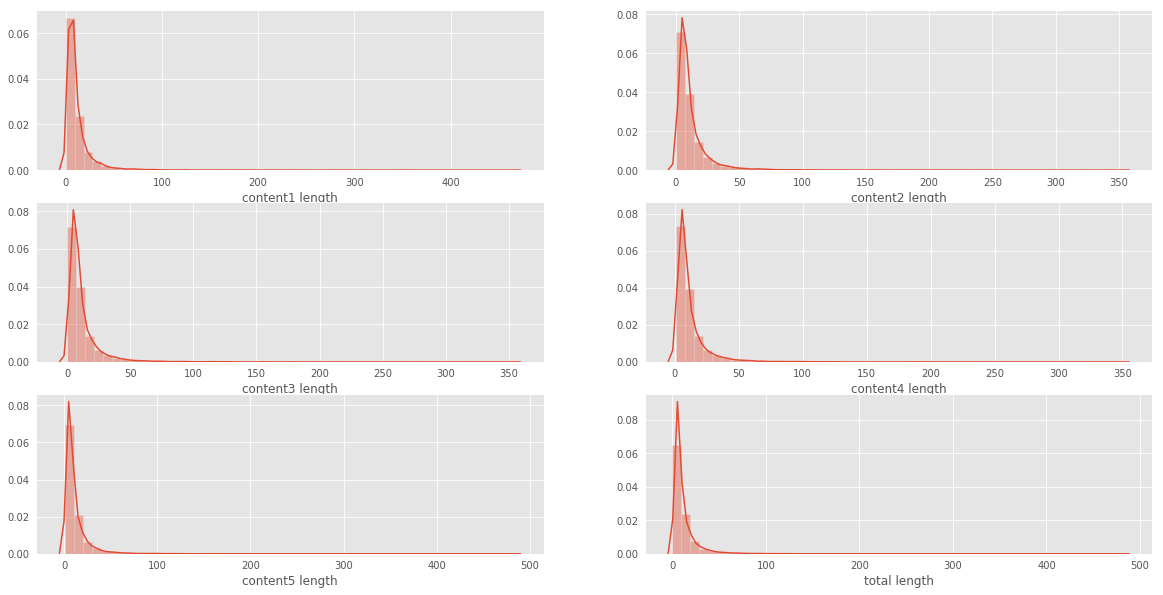

In [3]:
plt.figure(figsize=(20,10))
plt.subplot(321)
sns.distplot(train_content1_paras, axlabel='content1 length')
plt.subplot(322)
sns.distplot(train_content2_paras, axlabel='content2 length')
plt.subplot(323)
sns.distplot(train_content3_paras, axlabel='content3 length')
plt.subplot(324)
sns.distplot(train_content4_paras, axlabel='content4 length')
plt.subplot(325)
sns.distplot(train_content5_paras, axlabel='content5 length')
plt.subplot(326)
sns.distplot(train_content1_paras + train_content2_paras + train_content3_paras + 
             train_content4_paras + train_content5_paras, axlabel='total length')
plt.show()